In [4]:
import os
import torch
import torch.nn as nn
import torchvision.models
import collections
import math
import torch.nn.functional as F
import imagenet.mobilenet
from torch import optim
from pathlib import Path

import models

In [6]:
from dataloaders.nyu import NYUDataset

In [21]:
def train(dataset, net=None, criterion=None, optimizer=None, batch_size=8, lr=3e-4, epochs=20, device=None):
    log = []
    if device is not None:
        net.to(device)
    
    if optimizer is None:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    
    stats_step = (len(dataset) // 10 // batch_size) + 1
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            if device is not None:
                inputs = inputs.to(device)
                targets = targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            if torch.isnan(loss).any():
                warnings.warn("nan loss! skip update")
                print(f"last loss: {loss.item()}")
                break
            running_loss += loss.item()
            if (i % stats_step == 0):
                print(f"epoch {epoch}|{i}; total loss:{running_loss / stats_step}")
                print(f"last losses: {loss.item()}")
                log.append(loss.item())
                running_loss = 0.0
            loss.backward()
            optimizer.step()
    print('Finished Training')
    return net, log

# CIFAR pretrain

In [ ]:
from torchvision import transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(228)])

imagenet_data = torchvision.datasets.CIFAR100('/DATA/vashchilko/', train=True, transform=transform)

In [ ]:
net = imagenet.mobilenet.MobileNet()
lr = 0.001
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 50
device = torch.device('cuda:1')

In [ ]:
trained_net, log = train(imagenet_data, net=net, criterion=criterion,
                    batch_size=batch_size, lr=lr,
                    epochs=epochs, device=device)

In [ ]:
torch.save(trained_net, 'cifar100.pth')

# Training on NYUv2

In [11]:
base_nyu = Path("/DATA/vashchilko/nyudepthv2")
traindir_nyu = base_nyu / 'train'
valdir_nyu = base_nyu / 'val'

assert traindir_nyu.exists(), "Set your own path to train"
assert valdir_nyu.exists(), "Set your own path to val"

In [12]:
train_dataset = NYUDataset(traindir_nyu, split='train')

In [13]:
net = models.Model(pretrained=True)
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
criterion = nn.MSELoss()
batch_size = 8
epochs = 12
device = torch.device('cuda:1')

In [22]:
%%time
trained_net, log = train(train_dataset, net=net, criterion=criterion,
                    batch_size=batch_size, lr=lr,
                    epochs=epochs, device=device)

epoch 0|0; total loss:0.0022989452696170936
last losses: 1.351779818534851
epoch 0|588; total loss:1.272676516197571
last losses: 1.5709701776504517
epoch 0|1176; total loss:1.1741973229107403
last losses: 0.9804214239120483
epoch 0|1764; total loss:1.1480169182731992
last losses: 1.0093472003936768
epoch 0|2352; total loss:1.1585689032969833
last losses: 0.6075201034545898
epoch 0|2940; total loss:1.1448784498434488
last losses: 0.7713473439216614
epoch 0|3528; total loss:1.16387495117224
last losses: 0.8443320989608765
epoch 0|4116; total loss:1.0776419823064285
last losses: 1.341620922088623
epoch 0|4704; total loss:1.0586539297079554
last losses: 0.5733919739723206
epoch 0|5292; total loss:1.0722518982935925
last losses: 1.2913134098052979
epoch 1|0; total loss:0.0014137655091123517
last losses: 0.8312941193580627
epoch 1|588; total loss:1.076187023956354
last losses: 0.8122109770774841
epoch 1|1176; total loss:1.0618647486478292
last losses: 1.2994384765625
epoch 1|1764; total los

epoch 10|5292; total loss:0.7363154775634104
last losses: 0.42832890152931213
epoch 11|0; total loss:0.0009531710220842945
last losses: 0.5604645609855652
epoch 11|588; total loss:0.7320137800408059
last losses: 0.9319972991943359
epoch 11|1176; total loss:0.7321641900050803
last losses: 0.7073490023612976
epoch 11|1764; total loss:0.6941001324021087
last losses: 0.5526056885719299
epoch 11|2352; total loss:0.7264693145494477
last losses: 0.42986613512039185
epoch 11|2940; total loss:0.7009551628004937
last losses: 0.7258827090263367
epoch 11|3528; total loss:0.6741669128591917
last losses: 0.5318284034729004
epoch 11|4116; total loss:0.7436414577928531
last losses: 0.23696409165859222
epoch 11|4704; total loss:0.7173741170946433
last losses: 0.7604120969772339
epoch 11|5292; total loss:0.6813082226938536
last losses: 0.4934251606464386
Finished Training
CPU times: user 1h 14min 59s, sys: 6min 52s, total: 1h 21min 51s
Wall time: 4h 4min 9s


In [23]:
#torch.save(trained_net, 'trained2.pth')

In [24]:
torch.save(trained_net.state_dict(), 'trained2_state.pth')

In [26]:
import numpy as np
np.save('trainlog', np.array(log))

In [27]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'MSE loss')

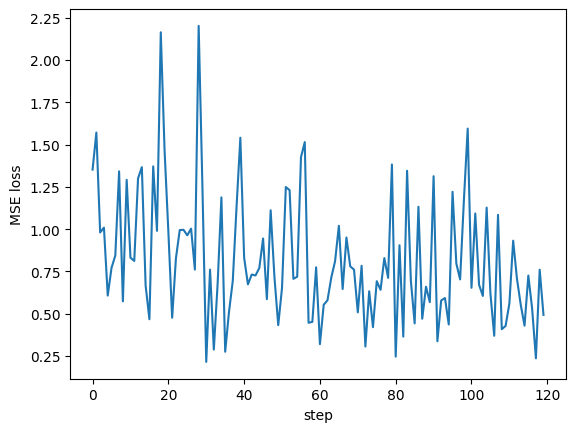

In [39]:
plt.plot(log)
plt.xlabel('step')
plt.ylabel('MSE loss')